# Data visualization - Breakdown by ASVs (Figure 3)

## Before you start

Run the accompanying shell script `fig2_preprocess.sh` found in this directory, which should run out-of-the-box.

That script is a re-implementation of the one found in `scripts/preprocess/agglomerate_asvs.sh`. Effectively, it will generate a collection of dataset pickle files -- essentially copies of ones used in the inference -- but with the first two timepoints `t=0, t=0.5` re-inserted.

In [1]:
# import statements
from typing import *
import mdsine2 as md2
import pandas as pd
import numpy as np
import argparse
import os

import matplotlib
from matplotlib import rcParams
from matplotlib import font_manager
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


#import matplotlib.font_manager
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.patches import Rectangle
from matplotlib.colors import LogNorm
from matplotlib import rcParams
from matplotlib import font_manager
from matplotlib.lines import Line2D

[DEBUG] Using default logger (stdout, stderr).


In [2]:
# Plot configuration
rcParams['pdf.fonttype'] = 42
PERTURBATION_COLOR = "orange"
CUTOFF_FRAC_ABUNDANCE = 0.005  # Aggregation of abundances below this threhold

In [3]:
# Data files, to be generated by fig3_preprocess.sh shell script

data_dir = Path('./gibson_full_timepoints')
healthy_inoc_pkl = data_dir / 'healthy' / 'gibson_inoculum_agg_full_timepoints.pkl'
healthy_pkl = data_dir / 'healthy' / 'gibson_healthy_agg_full_timepoints.pkl'
uc_inoc_pkl = data_dir / 'uc' / 'gibson_inoculum_agg_full_timepoints.pkl'
uc_pkl = data_dir / 'uc' / 'gibson_uc_agg_full_timepoints.pkl'

assert healthy_inoc_pkl.exists(), f"{healthy_inoc_pkl} must exist! Run the accompanying shell script (fig2_preprocess.sh) first."
assert healthy_pkl.exists(), f"{healthy_pkl} must exist! Run the accompanying shell script (fig2_preprocess.sh) first."
assert uc_inoc_pkl.exists(), f"{uc_inoc_pkl} must exist! Run the accompanying shell script (fig2_preprocess.sh) first."
assert uc_pkl.exists(), f"{uc_pkl} must exist! Run the accompanying shell script (fig2_preprocess.sh) first."

subjset_healthy = md2.Study.load(healthy_pkl)
subjset_healthy_inoc = md2.Study.load(healthy_inoc_pkl)
subjset_uc = md2.Study.load(uc_pkl)
subjset_uc_inoc = md2.Study.load(uc_inoc_pkl)

table_dir = Path("tables/fig2_dataset")
table_dir.mkdir(exist_ok=True, parents=True)
Path("plots").mkdir(exist_ok=True, parents=True)

True
True
True
True


# Experiment timeline.

In [4]:
def draw_experiment(ax, subjset, day_fontsize=13, pert_fontsize=13, legend_fontsize=13, marker_size=5):
    """render figure illustrating the experiment"""
    times = []
    for subj in subjset:
        times = np.append(times, subj.times)
    times = np.sort(np.unique(times))

    y = [-0.1 for t in times]
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.xaxis.set_minor_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_minor_locator(plt.NullLocator())

    markerline, stemlines, baseline = ax.stem(times, y, linefmt='none')
    baseline.set_color('black')
    markerline.set_color('black')
    markerline.set_markersize(marker_size)

    x = np.arange(0, np.max(times), step=10)
    labels = ['Day {}'.format(int(t)) for t in x]

    for ylim in [0.15, -0.35]:
        y = [ylim for t in x]
        markerline, stemlines, baseline = ax.stem(x, y)
        stemlines.set_color("black")
        baseline.set_color('black')
        markerline.set_color('none')
    for i in range(len(labels)):
        label = labels[i]
        xpos = x[i]
        ax.text(xpos-.3, -.35, label, horizontalalignment='right', fontsize=day_fontsize)
    x = np.arange(0,np.max(times),2)
    for ylim in [0.07, -0.07]:
        y = [ylim for t in x]
        markerline, stemlines, baseline = ax.stem(x, y)
        stemlines.set_color("black")
        baseline.set_color('black')
        markerline.set_color('none')
    subj_ = None
    for subj in subjset:
        subj_ = subj
        break

    times_li = list(times)

    for perturbation in subjset.perturbations:
        name = perturbation.name
        x = (perturbation.ends[subj_.name] + perturbation.starts[subj_.name])/2
        ax.text(
            x, 0.25, name.capitalize(), 
            horizontalalignment='center', fontsize=pert_fontsize
        )
        starts = np.asarray([perturbation.starts[subj_.name]])
        ends = np.asarray([perturbation.ends[subj_.name]])
        ax.barh(
            y=[0 for i in range(len(starts))], width=ends-starts, height=0.1,
            left=starts, color='darkgrey'
        )
    
    # Create custom legend elements
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='Fecal Sample Collection'),
    ]
    legend_xpos = 1.0
    legend_ypos = 0.5
    ax.legend(handles=legend_elements, bbox_to_anchor=(legend_xpos, legend_ypos), loc='center left', fontsize=legend_fontsize)

## Healthy

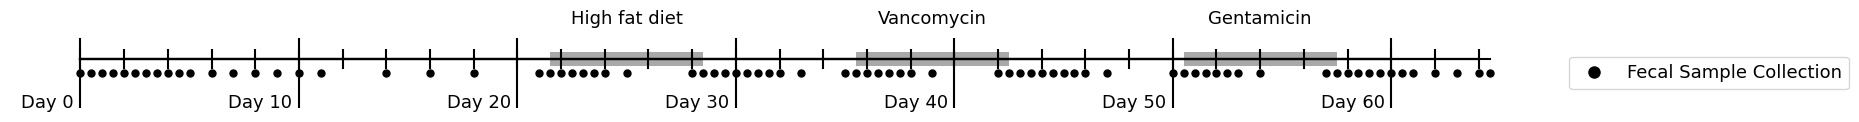

In [5]:
fig, ax = plt.subplots(figsize=(20, 1))
draw_experiment(ax, subjset_healthy)

## UC

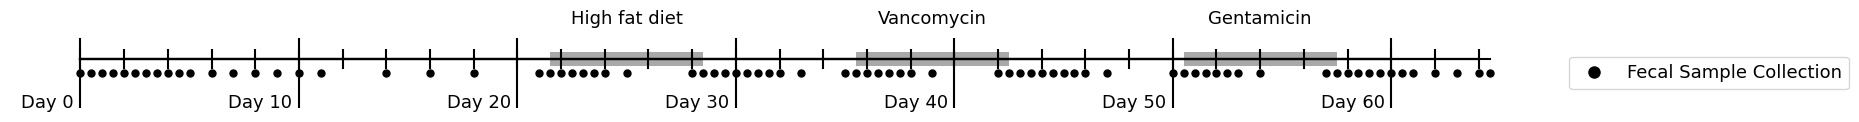

In [6]:
fig, ax = plt.subplots(figsize=(20, 1))
draw_experiment(ax, subjset_uc)

# Determine which taxa to plot

## Helper Functions

In [7]:
# Function for extracting relevant taxa and abundances

def relabund_df_aggregated(subjset, data_mode='abs'):
    subjset.taxa.generate_consensus_taxonomies()
    tax_df = subjset.taxa.write_taxonomy_to_csv().set_index('name')
    abund_dfs = []
    for subj in subjset:
        abund_df = subj.df()[data_mode]
        times = abund_df.columns
        abund_dfs.append(
            abund_df.merge(
                tax_df, left_index=True, right_index=True
            ).groupby(
                ['phylum', 'order', 'family']
            )[times].sum()
        )

    cumulative_df = abund_dfs[0]
    for df in abund_dfs[1:]:
        cumulative_df = cumulative_df.add(df, axis='columns', fill_value=0)
    relabund_df = cumulative_df / cumulative_df.sum()
    return relabund_df


def filter_taxa(relabund_df) -> Tuple[pd.Index, pd.Index]:
    # Only keep taxa that have relabund mean exceeding threshold.
    to_keep = relabund_df.loc[relabund_df.mean(axis=1) > CUTOFF_FRAC_ABUNDANCE]
    to_remove = relabund_df.loc[relabund_df.mean(axis=1) <= CUTOFF_FRAC_ABUNDANCE]
    to_keep = to_keep.assign(
        Avg=np.mean(to_keep.values, axis=1)
    ).sort_values('Avg', ascending=False).drop(columns=['Avg'])
    return to_keep.index, to_remove.index


## Code to invoke above functions.

In [8]:
# ===== Healthy
# Get the relative abundances over time.
healthy_relabund_df = relabund_df_aggregated(subjset_healthy, data_mode='abs')
healthy_to_keep, healthy_to_remove = filter_taxa(healthy_relabund_df)

# Print result.
print("Taxa to plot (ORDER, FAMILY):\n")
for phylum, order, family in healthy_to_keep:
    print(f'{phylum}, {order}, {family}')

Taxa to plot (ORDER, FAMILY):

Bacteroidetes, Bacteroidales, Bacteroidaceae
Verrucomicrobia, Verrucomicrobiales, Akkermansiaceae
Bacteroidetes, Bacteroidales, Porphyromonadaceae
Firmicutes, Clostridiales, Lachnospiraceae
Proteobacteria, Burkholderiales, Sutterellaceae
Proteobacteria, Enterobacterales, Enterobacteriaceae
Firmicutes, Acidaminococcales, Acidaminococcaceae
Bacteroidetes, Bacteroidales, Prevotellaceae
Proteobacteria, Desulfovibrionales, Desulfovibrionaceae
Firmicutes, Erysipelotrichales, Erysipelotrichaceae
Firmicutes, Clostridiales, Ruminococcaceae
Firmicutes, Clostridiales, Clostridiaceae_1
Bacteroidetes, Bacteroidales, Rikenellaceae
Firmicutes, Clostridiales, Peptostreptococcaceae
Bacteroidetes, Bacteroidales, Barnesiellaceae


In [9]:
# ===== UC
# Get the relative abundances over time.
uc_relabund_df = relabund_df_aggregated(subjset_uc, data_mode='abs')
uc_to_keep, uc_to_remove = filter_taxa(uc_relabund_df)

# Print result.
print("Taxa to plot (ORDER, FAMILY):\n")
for phylum, order, family in uc_to_keep:
    print(f'{phylum}, {order}, {family}')

Taxa to plot (ORDER, FAMILY):

Bacteroidetes, Bacteroidales, Bacteroidaceae
Verrucomicrobia, Verrucomicrobiales, Akkermansiaceae
Firmicutes, Clostridiales, Lachnospiraceae
Proteobacteria, Burkholderiales, Sutterellaceae
Bacteroidetes, Bacteroidales, Porphyromonadaceae
Firmicutes, Clostridiales, Ruminococcaceae
Firmicutes, Erysipelotrichales, Erysipelotrichaceae
Firmicutes, Clostridiales, Clostridiaceae_1


# Color Palette -- Family-Level

In [10]:
sns.color_palette('pastel', n_colors=10)

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

In [11]:
# This also decides the color palette.
colors = np.concatenate([sns.color_palette('muted', n_colors=10), sns.color_palette("dark", n_colors=10), sns.color_palette("pastel", n_colors=10)])
palette = {}
i = 0
for phylum, order, family in list(healthy_to_keep) + list(uc_to_keep):
    taxa_key = f'{order} {family}'
    if taxa_key in palette:
        continue
    else:
        palette[taxa_key] = colors[i]
        i += 1
palette[f'Other < {CUTOFF_FRAC_ABUNDANCE * 100}%'] = colors[i+1]

# Plot time-series abundance profiles.

## Helper code: function definitions

In [12]:
# Plotting code.

def geom_mean(x):
    return np.exp(np.log(x).mean())


def plot_qpcr(subjset, ax, lineplot_kwargs={}):
    #plot the absolute abundance
    qpcr_meas = {}
    for subj in subjset:
        for t in subj.times:
            if t not in qpcr_meas:
                qpcr_meas[t] = []
            qpcr_meas[t].append(subj.qpcr[t].mean())

    qpcr_meas = { t: geom_mean(vals) for t, vals in qpcr_meas.items() }
    times_qpcr = np.sort(list(qpcr_meas.keys()))
    qpcr_vals = [ qpcr_meas[t] for t in times_qpcr ]

    ax.plot(
        np.arange(0, len(times_qpcr)),  # draw the dot at the midpoint, to align with the bars in plot_relabund being centered.
        qpcr_vals, 
        marker='o', 
        linestyle='-',
        color='black',
        **lineplot_kwargs
    )
    ax.set_yscale('log')
    ax.set_ylabel('CFUs/g')

    max_qpcr_value = np.max(qpcr_vals)
    ax.set_ylim(bottom = 1e9, top = max_qpcr_value * (1.25))
    ax.set_yticks([1e10, 1e11])
    return times_qpcr


def plot_relabund(relabund_df, to_keep, to_remove, ax, palette, show_legend: bool = True):
    """
    Plot the relative abundances as a stacked bar chart.
    """
    # Only plot the OTUs that have mean relabund exceeding threshold.
    to_keep = relabund_df.loc[to_keep]
    to_remove = relabund_df.loc[to_remove]
    
    relabund_df = to_keep.assign(
        Avg=np.mean(to_keep.values, axis=1)
    ).sort_values('Avg', ascending=False).drop(columns=['Avg'])
    
    # Add a row for low-abundance (collected into "Other" category)
    relabund_df.loc[('Other', 'Other', f'< {CUTOFF_FRAC_ABUNDANCE * 100}%'), :] = to_remove.sum().values

    # Do the plotting.
    num_t = relabund_df.shape[1]
    num_r = relabund_df.shape[0]

    bottom = np.zeros(num_t)
    for (phylum, order, family), row in relabund_df.iloc[::-1].iterrows():
        ax.bar(
            np.arange(0, num_t),
            row.values,
            bottom=bottom,
            label=f'{order} {family}',
            color=palette[f'{order} {family}'],
            width=1.0,
            
        )
        bottom += row.values

    times = np.asarray(list(relabund_df.columns))
    xlocs = np.arange(0, len(times), step = 10)
    ax.set_xticks(xlocs)
    ax.set_xticklabels(times[xlocs])
    ax.set_ylim([0, 1])
    ax.set_xlim([-0.5, 0.5 + num_t - 1])

    if show_legend:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1.0, 0.5))
    

def add_perturbation_annotation(
    perturbations,
    timepoint_order,
    target_subj,
    ax,
    pert_fill_alpha: float = 0.3,
    show_label: bool = False,
    pert_fontsize: int = 12,
    vline_kwargs={'lw': 2}
):
    times = np.array(target_subj.times)
    if perturbations is None or len(perturbations) == 0:
        return

    times_to_idx = {t: i for i, t in enumerate(timepoint_order)}
    
    subj = target_subj.name
    for pidx, perturbation in enumerate(perturbations):
        if subj not in perturbation.starts or subj not in perturbation.ends:
            continue

        t_start = perturbation.starts[subj]
        t_end = perturbation.ends[subj]
        start = times_to_idx[t_start]
        end = times_to_idx[t_end]
        if pert_fill_alpha > 0.0:
            ax.axvspan(
                xmin=start,
                xmax=end,
                facecolor=PERTURBATION_COLOR,
                alpha=pert_fill_alpha, 
                zorder=-10000
            )
        ax.axvline(x=start, color='black', linestyle='--', **vline_kwargs)
        ax.axvline(x=end, color='black', linestyle='--', **vline_kwargs)

        if show_label:
            import matplotlib.transforms as transforms
            trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)        
            ax.text(np.mean([start, end]), 1.0, perturbation.name, horizontalalignment='center', verticalalignment='bottom', transform=trans, fontsize=pert_fontsize)

## Healthy

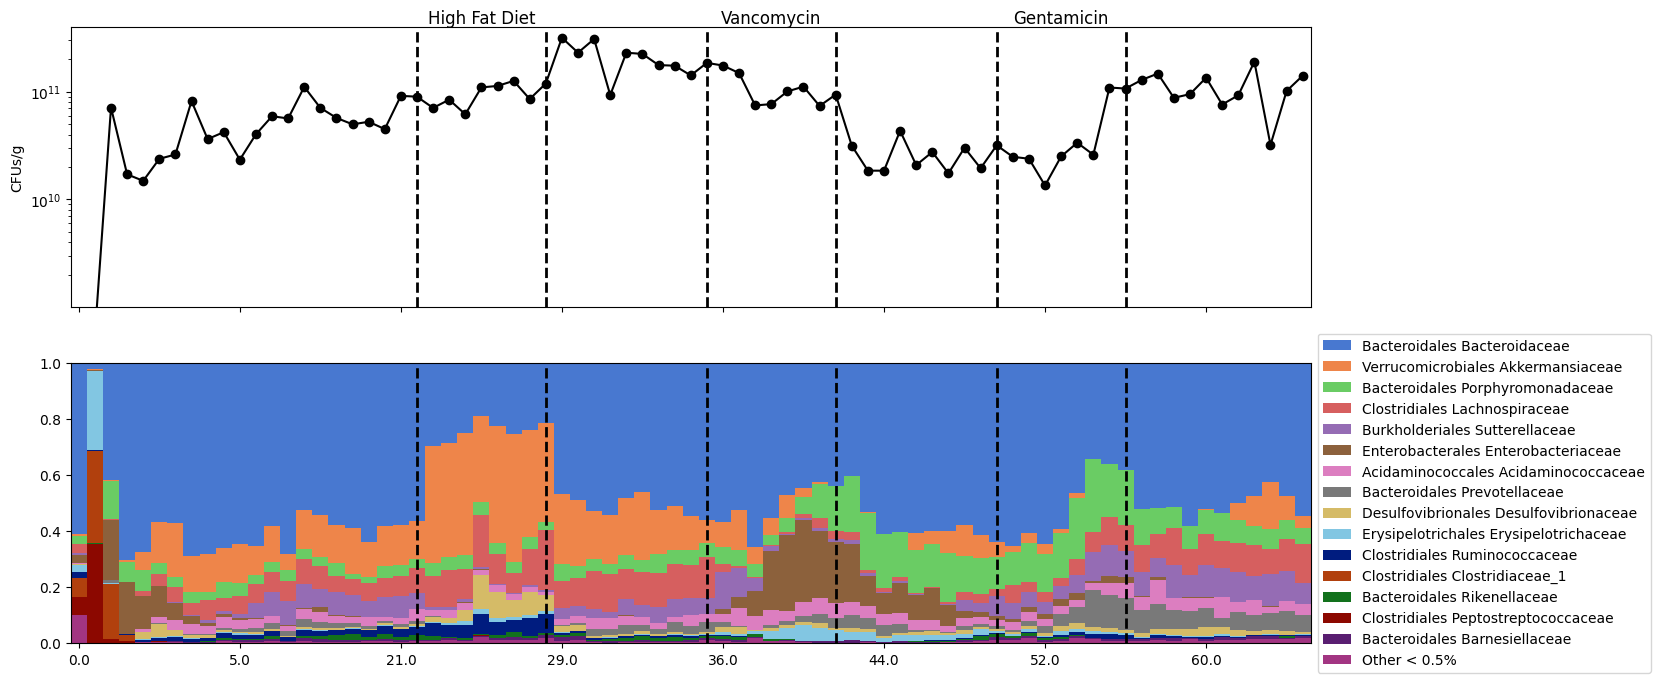

In [13]:
# Render plots.
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(16, 8))
times_qpcr = plot_qpcr(subjset_healthy, ax=ax[0])
plot_relabund(healthy_relabund_df, healthy_to_keep, healthy_to_remove, ax=ax[1], palette=palette, show_legend=True)

# Plot.
add_perturbation_annotation(subjset_healthy.perturbations, times_qpcr, subjset_healthy['2'], ax[0], pert_fill_alpha=0.0, show_label=True)
add_perturbation_annotation(subjset_healthy.perturbations, times_qpcr, subjset_healthy['2'], ax[1], pert_fill_alpha=0.0, show_label=False)

## UC

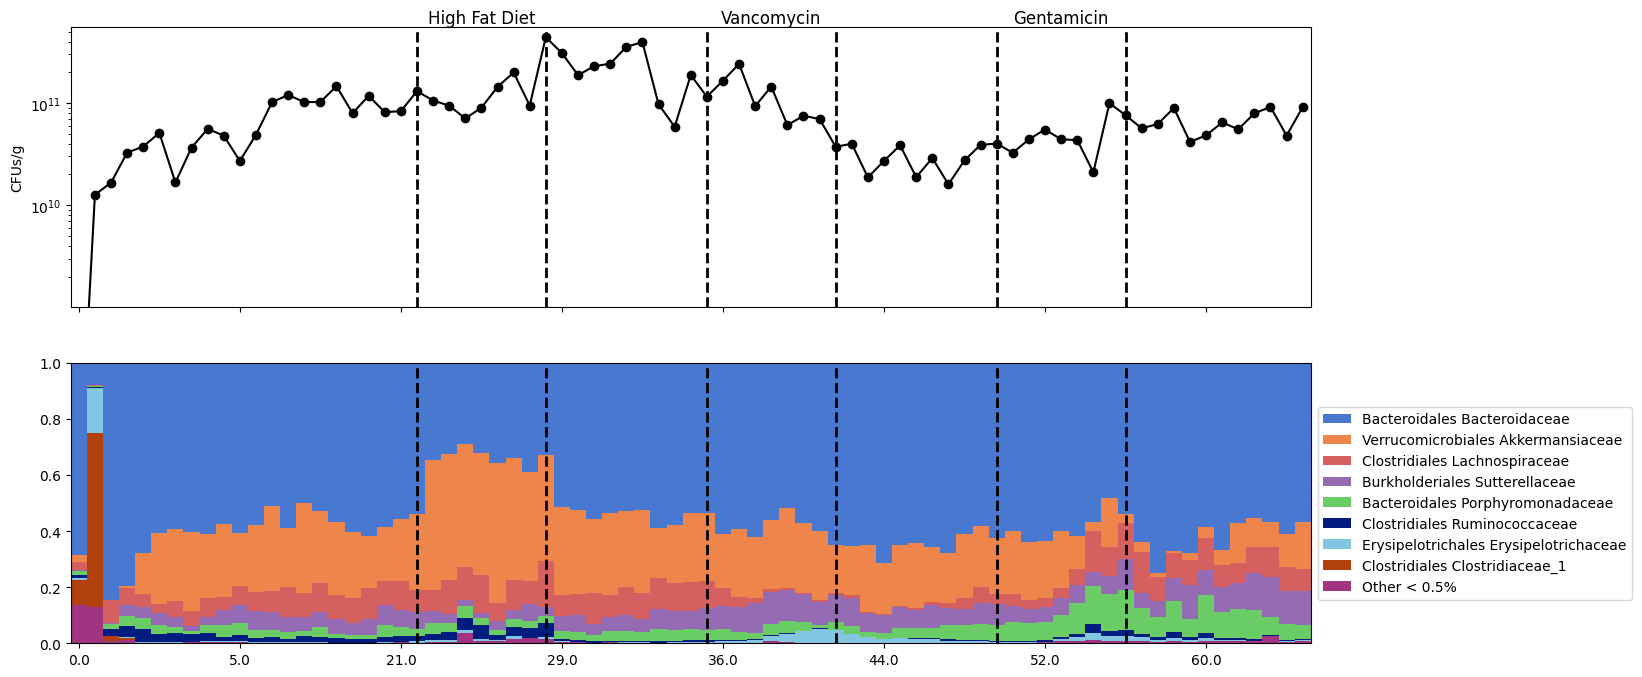

In [14]:
# Render plots.
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(16, 8))
times_qpcr = plot_qpcr(subjset_uc, ax=ax[0])
plot_relabund(uc_relabund_df, uc_to_keep, uc_to_remove, ax=ax[1], palette=palette)

# Plot.
add_perturbation_annotation(subjset_uc.perturbations, times_qpcr, subjset_uc['6'], ax[0], pert_fill_alpha=0.0, show_label=True)
add_perturbation_annotation(subjset_uc.perturbations, times_qpcr, subjset_uc['6'], ax[1], pert_fill_alpha=0.0, show_label=False)

# Relative abundances at family level, for inoculum

## Healthy inoculum

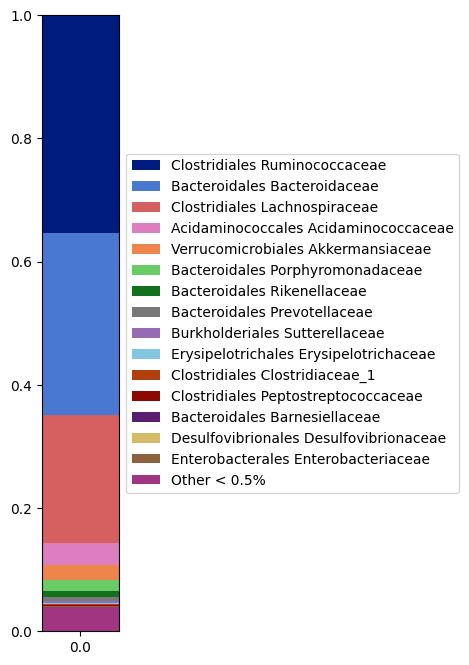

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(1, 8))

inoc_healthy_relabund_df = relabund_df_aggregated(subjset_healthy_inoc, data_mode='raw')
plot_relabund(inoc_healthy_relabund_df, healthy_to_keep, healthy_to_remove, ax=ax, palette=palette)

## UC inoculum

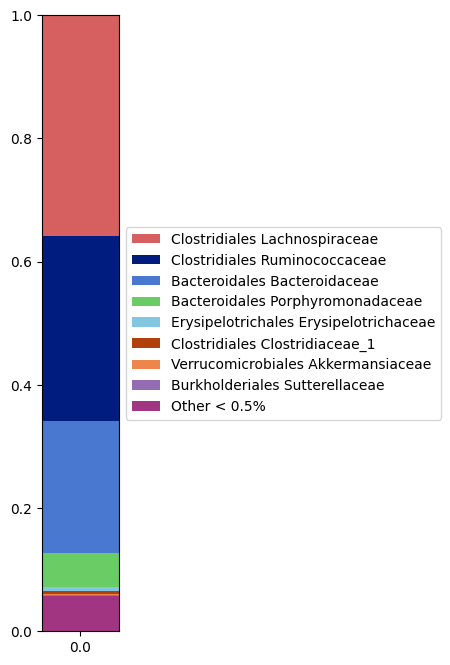

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(1, 8))

inoc_uc_relabund_df = relabund_df_aggregated(subjset_uc_inoc, data_mode='raw')
plot_relabund(inoc_uc_relabund_df, uc_to_keep, uc_to_remove, ax=ax, palette=palette)

# Relative abundance of the top 100 abundant taxa.

In [17]:
# Some code for plotting

def next_biggest(target, array):
    """implemements a binary search to find the first position of the item
        in the array that is greater than or equal to target"""

    start = 0
    end = len(array) - 1
    ans = -1
    while start <= end:
        mid = (start+end)//2
        if array[mid] < target:
            start = mid + 1
        else:
            ans = mid
            end = mid - 1

    return ans
    

def rel_abundance_plot(subject, ax, n, t, label_kwargs=dict(size=18, fontweight="bold"), tick_kwargs=dict(fontsize=15)):
    """plots the relative abundances of top n bugs at time t"""

    try:
        abund_series = subject.df()["rel"][t]
        names = [taxon.name for taxon in subject.taxa]
        abund_series.index = names
        abund_series = abund_series.sort_values(ascending=False).head(100)

        abund_df = abund_series.to_frame().reset_index()
        abund_df.columns = ["otu_names", "abundance"]

        axis = sns.barplot(y="abundance", x="otu_names", data=abund_df,
            color="tab:grey")
        axis.set_xlabel("Top 100 most abundant ASVs", **label_kwargs)
        #axis.set_xlabel("")
        axis.set_ylabel("Relative Abundace")
        axis.set_ylim(1e-5, 0.5)
        axis.set_yscale("log")
        axis.set_yticks([1e-4, 1e-3, 1e-2, 1e-1])
        axis.set_yticklabels([r'$10^{-4}$', r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$'], **tick_kwargs)


        np_abundance = abund_df["abundance"].to_numpy()
        cdf = [np_abundance[0]]
        for i in range(1, np_abundance.shape[0]):
            cdf.append(cdf[i-1] + np_abundance[i])
        cdf = np.asarray(cdf)

        pos_50 = next_biggest(0.55, cdf)
        pos_90 = next_biggest(0.90, cdf)
        pos_99 = next_biggest(0.99, cdf)
        pos_999 = next_biggest(0.999, cdf)
        pos_9999 = next_biggest(0.9999, cdf)

        new_xticks = [pos_50, pos_90, pos_99, pos_999, pos_9999]
        new_xticks = [x + 0.5 for x in new_xticks if x != -1]
        xtick_labels = ["50%", "90%", "99%", "99.9%", "99.99%"]
        xtick_labels = xtick_labels[:len(new_xticks)]

        otu_arr = abund_df["otu_names"].to_numpy()
        
        axis.set_xticks(new_xticks)
        axis.set_xticklabels(xtick_labels, **tick_kwargs)
        
        for x in new_xticks:
            axis.axvline(x=x, color="black", linestyle="--")

        abund_df["cdf"] = cdf
    except KeyError:
        print("No data available for time point {}. Please select a valid"\
            "time point".format(t))

## Healthy

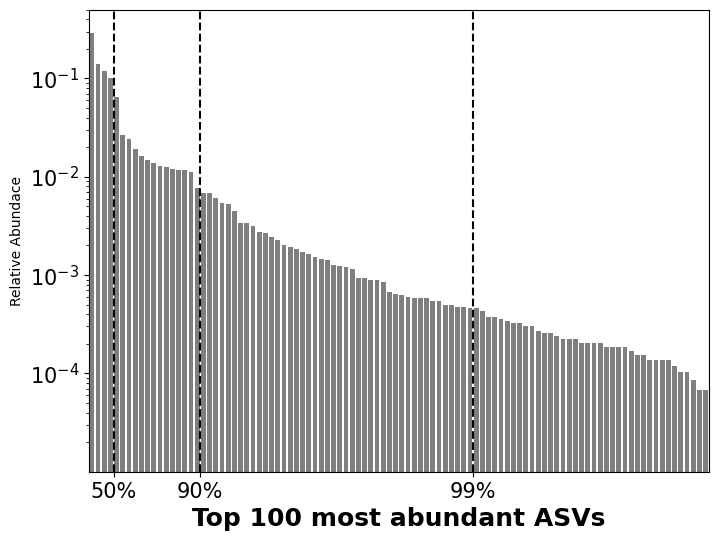

In [18]:
# Draw the plot.
fig, ax = plt.subplots(figsize=(8, 6))
rel_abundance_plot(subjset_healthy['2'], ax, n=100, t=10.0)

## UC

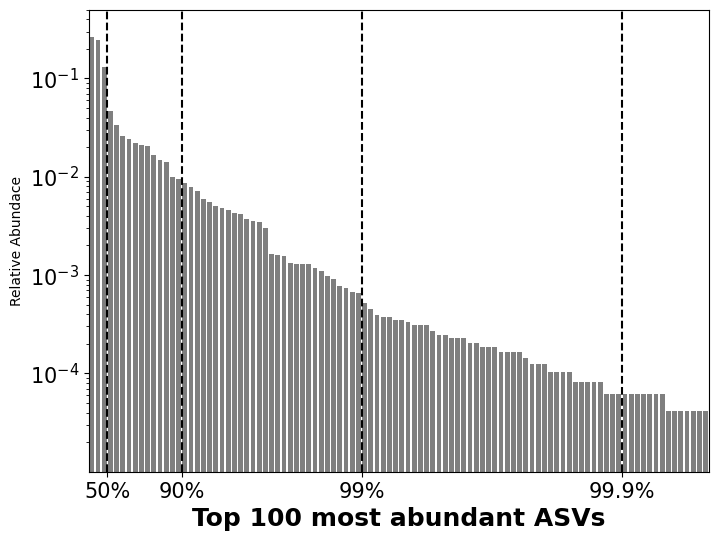

In [19]:
# Draw the plot.
fig, ax = plt.subplots(figsize=(8, 6))
rel_abundance_plot(subjset_uc['6'], ax, n=100, t=10.0)

# DeSeq analysis on taxa

In [20]:
healthy_deseq_dir = Path().resolve().parent / 'datasets' / 'gibson' / 'healthy' / 'differential_abundance'
uc_deseq_dir = Path().resolve().parent / 'datasets' / 'gibson' / 'uc' / 'differential_abundance'

In [21]:
from typing import Set, List

def make_deseq_df(csv_dir: Path, taxa_names: Set[str], cohort_name: str):
    """
    generates the df used to make the heatmap
    """
    hfd_df = pd.read_csv(csv_dir / f"{cohort_name}_of_window_1.csv", index_col=0)
    vanc_df = pd.read_csv(csv_dir / f"{cohort_name}_of_window_2.csv", index_col=0)
    gent_df = pd.read_csv(csv_dir / f"{cohort_name}_of_window_3.csv", index_col=0)
    

    # pick either the sign or NaN
    hfd_df['SignChange'] = np.where(
        (hfd_df['padj'] <= 0.05),
        np.sign(hfd_df['log2FoldChange']),
        np.full(shape=hfd_df.shape[0], fill_value=np.nan)
    )
    vanc_df['SignChange'] = np.where(
        (vanc_df['padj'] <= 0.05),
        np.sign(vanc_df['log2FoldChange']),
        np.full(shape=vanc_df.shape[0], fill_value=np.nan)
    )
    gent_df['SignChange'] = np.where(
        (gent_df['padj'] <= 0.05),
        np.sign(gent_df['log2FoldChange']),
        np.full(shape=gent_df.shape[0], fill_value=np.nan)
    )

    merged_df = hfd_df['SignChange'].rename("High Fat Diet").to_frame().merge(
        vanc_df['SignChange'].rename("Vancomycin").to_frame(), 
        left_index=True, right_index=True, 
    ).merge(
        gent_df['SignChange'].rename("Gentamicin").to_frame(), 
        left_index=True, right_index=True
    )
    
    # Truncate the long taxa names (in the deseq output) to just order and family (to match the plotting style above).
    merged_df['short_taxa_name'] = merged_df.index.str.split(' ', n=4).str[-2:].str.join(' ')

    return merged_df.loc[
        merged_df['short_taxa_name'].isin(taxa_names)
    ], merged_df.loc[
        (~np.isnan(merged_df['High Fat Diet']) | ~np.isnan(merged_df['Vancomycin']) | ~np.isnan(merged_df['Gentamicin']))
        & ~merged_df['short_taxa_name'].isin(taxa_names)
    ]

In [22]:
def make_heatmap_legend_combo(
    df, ax, 
    fontsize: int = 8, 
    order_x: float = 0.15, 
    family_x: float = 0.45,
    heatmap_x: float = 0.8,
    legend_patch_width: float = 0.1,
    legend_patch_height_ratio: float = 0.9,
    heatmap_font_size: int = 8,
    show_header: bool = True,
    show_pert_xlabel: bool = True,
    render_other_legend: bool = False,
    pert_abbreviations: Dict[str, str] = {},
    family_rename: Dict[str, str] = {},
):
    # render the text as a table. Could just use pyplot's table() command, but there are too many features hidden. Just rewrite it from scratch.
    df = df.sort_values('short_taxa_name')
    n_taxa = df.shape[0]
    cell_height = 1 / n_taxa
    
    n_heatmap_cols = len(df.columns)
    heatmap_cell_height = cell_height
    heatmap_overall_width = 1 - heatmap_x
    heatmap_cell_width = heatmap_overall_width / n_heatmap_cols

    legend_patch_height = legend_patch_height_ratio * cell_height
    legend_patch_x = (order_x - legend_patch_width) / 2
    legend_patch_padding = (cell_height - legend_patch_height) / 2

    perts_to_plot = [p_name for p_name in df.columns if p_name != 'short_taxa_name']
    print("Plotting differential abundance heatmap for: {}".format(perts_to_plot))

    if render_other_legend:
        other_taxa_label = f'Other < {CUTOFF_FRAC_ABUNDANCE * 100}%'
        legend_y = 1 + legend_patch_padding
        color = palette[other_taxa_label]
        legend_rect = Rectangle((legend_patch_x, legend_y), legend_patch_width, legend_patch_height, facecolor=color, edgecolor='white', linewidth=0.5)
        ax.add_patch(legend_rect)
        ax.text(
            order_x, 
            1 + (0.5 * cell_height), # top to bottom. need to invert the axis coordinates (origin=bottom left corner)
            other_taxa_label,
            va='center', ha='left'
        )
    if show_header:
        ax.text(
            order_x, 
            1.0 + (0.5 * cell_height), # top to bottom. need to invert the axis coordinates (origin=bottom left corner)
            "Order",
            va='center', ha='left'
        )
        ax.text(
            family_x, 
            1.0 + (0.5 * cell_height), # top to bottom. need to invert the axis coordinates (origin=bottom left corner)
            "Family",
            va='center', ha='left'
        )
        ax.text(
            heatmap_x, 
            1.0 + (0.5 * cell_height), # top to bottom. need to invert the axis coordinates (origin=bottom left corner)
            "Change",
            va='center', ha='left'
        )
    for row_idx, (full_taxa_name, row) in enumerate(df.iterrows()):
        phylum, pclass, order, family = full_taxa_name.split(" ")
            
        """ Legend colors """
        short_taxa_name = row['short_taxa_name']
        if short_taxa_name in palette:
            legend_y = 1 - ((1+row_idx) * cell_height) + legend_patch_padding
            color = palette[short_taxa_name]
            legend_rect = Rectangle((legend_patch_x, legend_y), legend_patch_width, legend_patch_height, facecolor=color, edgecolor='white', linewidth=0.5)
            ax.add_patch(legend_rect)

        """ Taxonomic name """
        if family == 'unknown' and order == 'unknown':
            if pclass != 'unknown':
                order = f'({pclass})'
                family = '(not resolved below class)'
            elif phylum != 'unknown':
                order = f'({phylum})'
                family = '(not resolved below phylum)'
            else:
                order = '(Bacteria)'
                family = '(not resolved below kingdom)'
        elif family == 'unknown':
            family = '(not resolved below order)'
        if family in family_rename:
            family = family_rename[family]
        ax.text(
            order_x, 
            1 - ((0.5 + row_idx) * cell_height), # top to bottom. need to invert the axis coordinates (origin=bottom left corner)
            order,
            va='center', ha='left'
        )
        ax.text(
            family_x, 
            1 - ((0.5 + row_idx) * cell_height), # top to bottom. need to invert the axis coordinates (origin=bottom left corner)
            family,
            va='center', ha='left'
        )

        """ differential expression heatmap """
        for col_idx, cell_col_name in enumerate(perts_to_plot):
            x = heatmap_x + (col_idx * heatmap_cell_width)
            y = 1 - ((1+row_idx) * cell_height)

            if np.isnan(row[cell_col_name]):
                heat_color = 'white'
                heat_symbol = ''
            elif row[cell_col_name] > 0:
                heat_color = 'tab:blue'
                heat_symbol = r'$+$'
            elif row[cell_col_name] < 0:
                heat_color = np.array([229., 131., 104.]) / 255.0
                heat_symbol = r'$-$'
            else:
                heat_color = 'white'
                heat_symbol = ''
            rect = Rectangle((x, y), heatmap_cell_width, heatmap_cell_height, facecolor=heat_color, edgecolor='black', linewidth=0.5)
            ax.add_patch(rect)
            if heat_symbol != '':
                ax.text(
                    x=x + rect.get_width() / 2., 
                    y=y + rect.get_height() / 2.,
                    s=heat_symbol,
                    ha='center', va='center', fontsize=heatmap_font_size
                )
    ax.axis('off')
    ax.set_xlim(legend_patch_x, 1.001)
    ax.set_ylim(-0.01, 1.0 + cell_height)

    if show_pert_xlabel:
        for col_idx, cell_col_name in enumerate(perts_to_plot):
            pert_label = pert_abbreviations.get(cell_col_name, cell_col_name)
            ax.text(
                x=heatmap_x + ((col_idx+0.5) * heatmap_cell_width),
                y=-0.01,
                s=pert_label,
                ha='center', va='top', fontsize=heatmap_font_size, rotation=90
            )

## Healthy

Plotting differential abundance heatmap for: ['High Fat Diet', 'Vancomycin', 'Gentamicin']
Plotting differential abundance heatmap for: ['High Fat Diet', 'Vancomycin', 'Gentamicin']


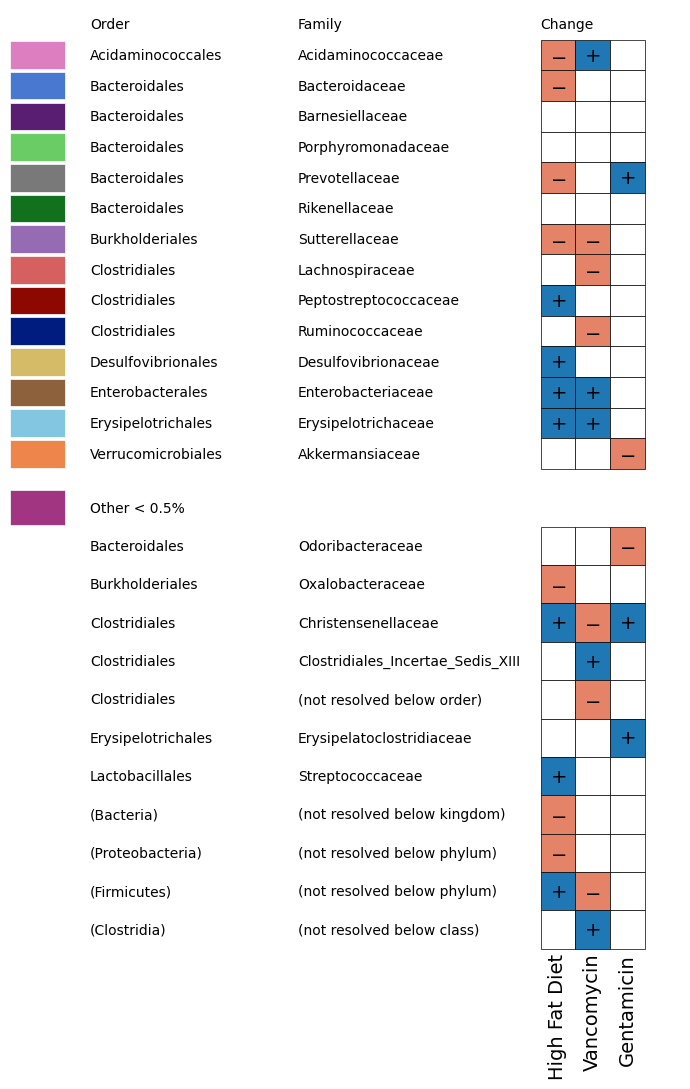

In [23]:
healthy_abundant_deseq_df, healthy_sparse_deseq_df = make_deseq_df(healthy_deseq_dir, set(palette.keys()), 'healthy')

fig, axes = plt.subplots(2, 1, figsize=(7, 11))
make_heatmap_legend_combo(
    healthy_abundant_deseq_df,
    axes[0],
    fontsize=10,
    legend_patch_width=0.08,
    heatmap_font_size=14, show_pert_xlabel=False
)
make_heatmap_legend_combo(
    healthy_sparse_deseq_df,
    axes[1],
    fontsize=10,
    heatmap_font_size=14,
    show_header=False,
    legend_patch_width=0.08,
    render_other_legend=True
)
fig.tight_layout()

In [24]:
healthy_deseq_dir

PosixPath('/data/local/sandbox/MDSINE2_Paper/datasets/gibson/healthy/differential_abundance')

## UC

Plotting differential abundance heatmap for: ['High Fat Diet', 'Vancomycin', 'Gentamicin']
Plotting differential abundance heatmap for: ['High Fat Diet', 'Vancomycin', 'Gentamicin']


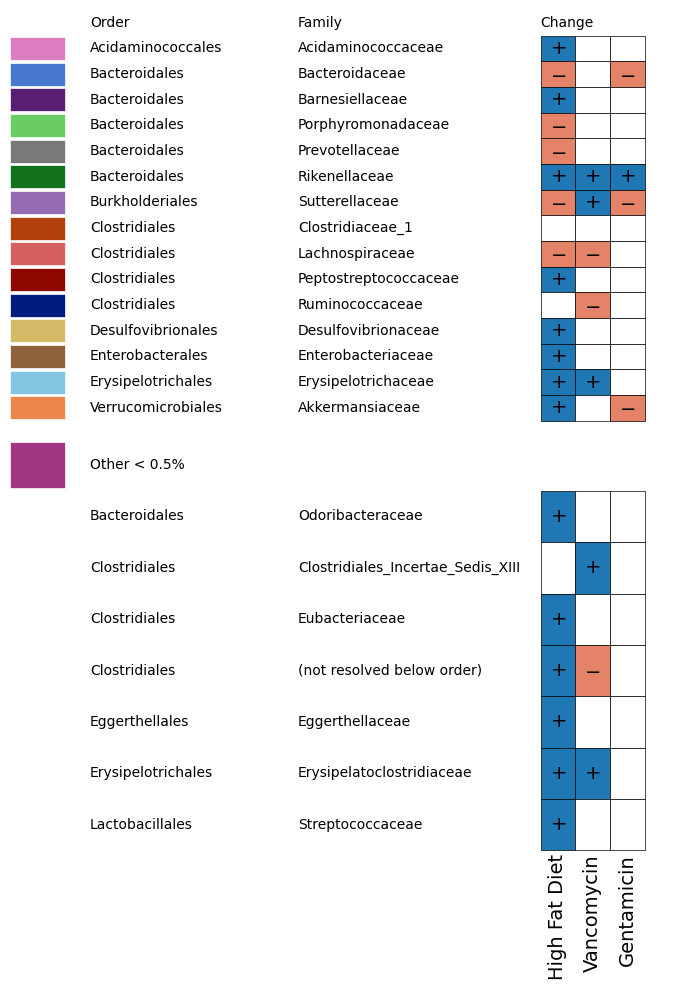

In [25]:
uc_abundant_deseq_df, uc_sparse_deseq_df = make_deseq_df(uc_deseq_dir, set(palette.keys()), 'uc')

fig, axes = plt.subplots(2, 1, figsize=(7, 10))
make_heatmap_legend_combo(
    uc_abundant_deseq_df,
    axes[0],
    fontsize=10,
    legend_patch_width=0.08,
    heatmap_font_size=14, show_pert_xlabel=False
)
make_heatmap_legend_combo(
    uc_sparse_deseq_df,
    axes[1],
    fontsize=10,
    heatmap_font_size=14,
    show_header=False,
    legend_patch_width=0.08,
    render_other_legend=True
)
fig.tight_layout()
uc_abundant_deseq_df.to_csv(table_dir / "uc_abundant_deseq.tsv", sep='\t', index=True)
uc_sparse_deseq_df.to_csv(table_dir / "uc_sparse_deseq.tsv", sep='\t', index=True)

# Figure-ready plots.

Put the above plots together into one, organized template.

In [26]:
import string
import matplotlib.transforms as mtransforms

def add_figure_labels(fig, axes, labels=None, x_offset: float = -25/72, y_offset: float = -9/72):
    """ add A/B/C/D labels """
    if labels is None:
        labels = [string.ascii_lowercase[n] for n in range(len(axes))]
    if len(labels) != len(axes):
        raise ValueError("Number of labels do not match number of axes.")
    for n, _ax in enumerate(axes):
        # _ax.text(-.1, 1.1, string.ascii_uppercase[n], transform=_ax.transAxes, size=20, weight='bold')
        trans = mtransforms.ScaledTranslation(x_offset, y_offset, fig.dpi_scale_trans)
        lbl = labels[n]
        _ax.text(
            0., 1.05, lbl, transform=_ax.transAxes + trans,
            va='bottom', fontfamily='sans-serif', weight='bold', size=15
        )

In [27]:
def render_fig3(subjset, reference_subj_id, relabund_df, inoc_relabund_df, taxa_to_keep, taxa_to_remove, abundant_deseq_df, sparse_deseq_df, pert_abbreviations, family_rename, figsize):
    fig, axes = plt.subplot_mosaic(
        mosaic=[
            ['timeseries', 'timeseries', 'timeseries', 'Empty0'],
            ['Empty1', 'qpcr', 'differential', 'differential'],
            ['inoculum', 'abund', 'differential', 'differential'],
            ['abund_hist', 'abund_hist', 'differential', 'differential'],
        ], 
        figsize=figsize,
        gridspec_kw={
            'height_ratios': [1, 2, 4, 5],
            'width_ratios': [0.5, 8, 4, 4],
            'hspace': 0.3, 'wspace': 0.05
        },
        # layout='constrained'
    )
    
    ## Hide empty axes
    for ax_key, ax in axes.items():
        if ax_key.startswith('Empty'):
            ax.axis('off')
    
    draw_experiment(axes['timeseries'], subjset, day_fontsize=11, pert_fontsize=11, legend_fontsize=10, marker_size=2)
    times_qpcr = plot_qpcr(subjset, ax=axes['qpcr'], lineplot_kwargs=dict(markersize=2, linewidth=1))
    plot_relabund(relabund_df, taxa_to_keep, taxa_to_remove, ax=axes['abund'], palette=palette, show_legend=False)
    
    add_perturbation_annotation(subjset.perturbations, times_qpcr, subjset[reference_subj_id], axes['qpcr'], pert_fill_alpha=0.0, show_label=True, vline_kwargs=dict(linewidth=1.0), pert_fontsize=8)
    add_perturbation_annotation(subjset.perturbations, times_qpcr, subjset[reference_subj_id], axes['abund'], pert_fill_alpha=0.0, show_label=False, vline_kwargs=dict(linewidth=1.0), pert_fontsize=8)
    axes['qpcr'].set_xticks([])
    axes['qpcr'].set_xlabel('Time (days)')
    axes['abund'].set_yticks([])
    axes['qpcr'].set_xlim(axes['abund'].get_xlim())
    axes['qpcr'].set_xticklabels([])
    
    plot_relabund(inoc_relabund_df, taxa_to_keep, taxa_to_remove, ax=axes['inoculum'], palette=palette, show_legend=False)
    axes['inoculum'].set_ylabel('Relative abundance')
    
    rel_abundance_plot(subjset[reference_subj_id], axes['abund_hist'], n=100, t=10.0, label_kwargs=dict(), tick_kwargs=dict())
    
    axes['differential'].axis('off')
    n_abund = abundant_deseq_df.shape[0]
    n_sparse = sparse_deseq_df.shape[0]
    abund_ax_height = n_abund / (n_abund + n_sparse)
    
    deseq_abund_axes = axes['differential'].inset_axes([0.0, 1 - abund_ax_height, 1.0, abund_ax_height])
    make_heatmap_legend_combo(
        abundant_deseq_df,
        deseq_abund_axes,
        fontsize=8,
        order_x=0.07,
        family_x=0.35,
        heatmap_x=0.82,
        legend_patch_width=0.05,
        legend_patch_height_ratio=0.8,
        heatmap_font_size=11, show_pert_xlabel=False,
        pert_abbreviations=pert_abbreviations, family_rename=family_rename
    )
    deseq_other_axes = axes['differential'].inset_axes([0.0, 0.0, 1.0, 1 - abund_ax_height])
    make_heatmap_legend_combo(
        sparse_deseq_df,
        deseq_other_axes,
        fontsize=8,
        order_x=0.07,
        family_x=0.35,
        heatmap_x=0.82,
        heatmap_font_size=11,
        show_header=False,
        legend_patch_width=0.05,
        legend_patch_height_ratio=0.8,
        render_other_legend=True,
        pert_abbreviations=pert_abbreviations, family_rename=family_rename
    )
    
    """ Figure labels """
    add_figure_labels(fig, [axes['timeseries']], 'A', x_offset=-0.5, y_offset=0.)
    add_figure_labels(fig, [axes['Empty1']], 'B', x_offset=-0.5, y_offset=0.)
    add_figure_labels(fig, [axes['differential']], 'C', x_offset=-0.0, y_offset=-0.25)
    add_figure_labels(fig, [axes['inoculum']], 'D', x_offset=-0.5, y_offset=0.)
    add_figure_labels(fig, [axes['abund']], 'E', x_offset=-0.1, y_offset=0.)
    add_figure_labels(fig, [axes['abund_hist']], 'F', x_offset=-0.5, y_offset=-0.15)
    
    fig.tight_layout()
    return fig, axes

Plotting differential abundance heatmap for: ['High Fat Diet', 'Vancomycin', 'Gentamicin']
Plotting differential abundance heatmap for: ['High Fat Diet', 'Vancomycin', 'Gentamicin']


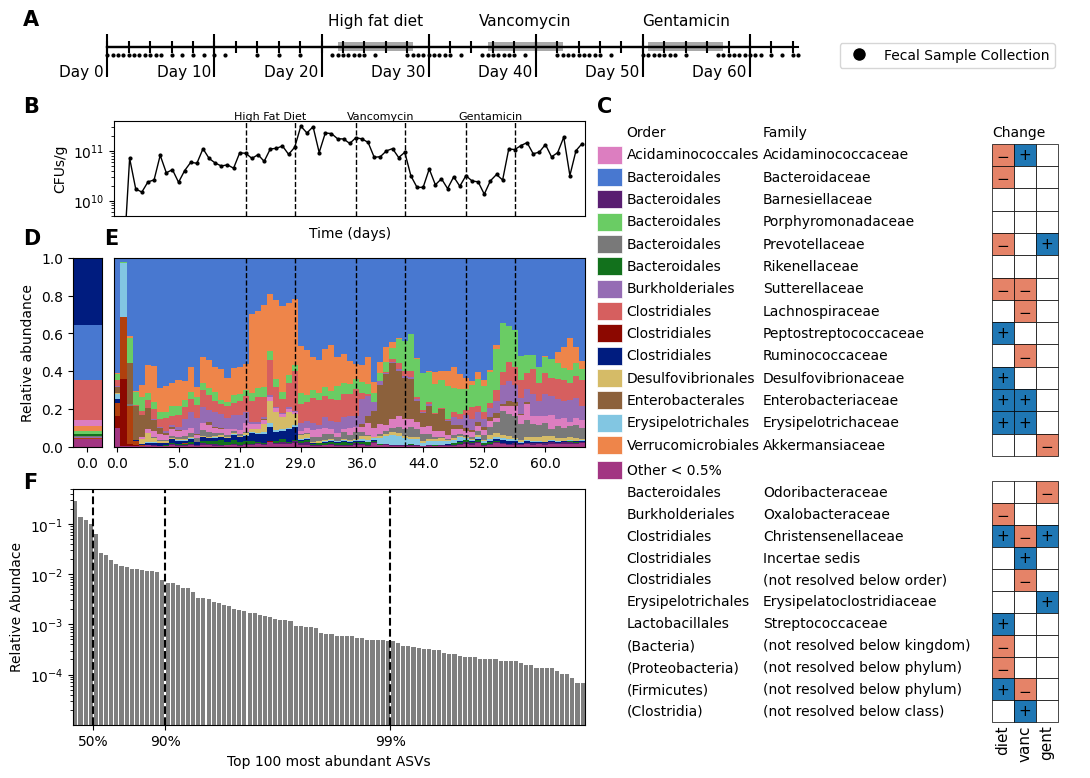

In [28]:
pert_abbreviations = {'High Fat Diet': 'diet', 'Vancomycin': 'vanc', 'Gentamicin': 'gent'}
family_rename = {'Clostridiales_Incertae_Sedis_XIII': 'Incertae sedis', 'Clostridiaceae_1': 'Clostridiaceae'}
healthy_abundant_deseq_df, healthy_sparse_deseq_df = make_deseq_df(healthy_deseq_dir, set(palette.keys()), 'healthy')
fig, ax = render_fig3(subjset_healthy, '2', healthy_relabund_df, inoc_healthy_relabund_df, 
                      healthy_to_keep, healthy_to_remove, healthy_abundant_deseq_df, healthy_sparse_deseq_df, figsize=(13, 9),
                      pert_abbreviations=pert_abbreviations, family_rename=family_rename)
ax['qpcr'].set_ylim(5 * 1e9, ax['qpcr'].get_ylim()[1])
plt.savefig("plots/fig3_healthy.pdf", bbox_inches='tight')

Plotting differential abundance heatmap for: ['High Fat Diet', 'Vancomycin', 'Gentamicin']
Plotting differential abundance heatmap for: ['High Fat Diet', 'Vancomycin', 'Gentamicin']


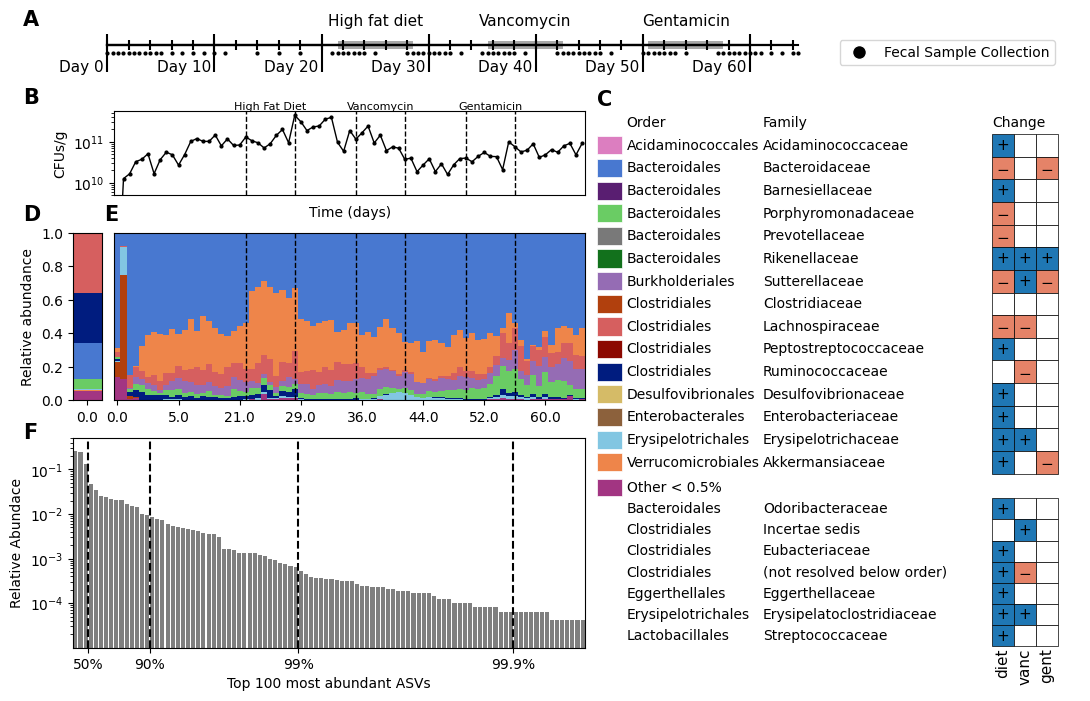

In [29]:
pert_abbreviations = {'High Fat Diet': 'diet', 'Vancomycin': 'vanc', 'Gentamicin': 'gent'}
family_rename = {'Clostridiales_Incertae_Sedis_XIII': 'Incertae sedis', 'Clostridiaceae_1': 'Clostridiaceae'}
uc_abundant_deseq_df, uc_sparse_deseq_df = make_deseq_df(uc_deseq_dir, set(palette.keys()), 'uc')
fig, ax = render_fig3(subjset_uc, '6', uc_relabund_df, inoc_uc_relabund_df, 
                      uc_to_keep, uc_to_remove, uc_abundant_deseq_df, uc_sparse_deseq_df, figsize=(13, 8),
                      pert_abbreviations=pert_abbreviations, family_rename=family_rename)
ax['qpcr'].set_ylim(5 * 1e9, ax['qpcr'].get_ylim()[1])
plt.savefig("plots/fig3_uc.pdf", bbox_inches='tight')

# Supplement figure

In [30]:
MISSING_PHYLA_KEY = f'Phyla with total abund < {CUTOFF_FRAC_ABUNDANCE * 100}%'


def make_deseq_df_phylum(csv_dir: Path, phylum_names: Set[str], cohort_name: str):
    """
    generates the df used to make the heatmap
    """
    hfd_df = pd.read_csv(csv_dir / f"{cohort_name}_phylum_window_1.csv", index_col=0)
    vanc_df = pd.read_csv(csv_dir / f"{cohort_name}_phylum_window_2.csv", index_col=0)
    gent_df = pd.read_csv(csv_dir / f"{cohort_name}_phylum_window_3.csv", index_col=0)
    

    # pick either the sign or NaN
    hfd_df['SignChange'] = np.where(
        (hfd_df['padj'] <= 0.05),
        np.sign(hfd_df['log2FoldChange']),
        np.full(shape=hfd_df.shape[0], fill_value=np.nan)
    )
    vanc_df['SignChange'] = np.where(
        (vanc_df['padj'] <= 0.05),
        np.sign(vanc_df['log2FoldChange']),
        np.full(shape=vanc_df.shape[0], fill_value=np.nan)
    )
    gent_df['SignChange'] = np.where(
        (gent_df['padj'] <= 0.05),
        np.sign(gent_df['log2FoldChange']),
        np.full(shape=gent_df.shape[0], fill_value=np.nan)
    )

    merged_df = hfd_df['SignChange'].rename("High Fat Diet").to_frame().merge(
        vanc_df['SignChange'].rename("Vancomycin").to_frame(), 
        left_index=True, right_index=True, 
    ).merge(
        gent_df['SignChange'].rename("Gentamicin").to_frame(), 
        left_index=True, right_index=True
    )

    return merged_df.loc[
        merged_df.index.isin(phylum_names)
    ], merged_df.loc[
        (~np.isnan(merged_df['High Fat Diet']) | ~np.isnan(merged_df['Vancomycin']) | ~np.isnan(merged_df['Gentamicin']))
        & ~merged_df.index.isin(phylum_names)
    ]


def plot_relabund_phylum(relabund_df, to_keep, to_remove, ax, palette, show_legend: bool = True):
    """
    Plot the relative abundances as a stacked bar chart.
    """
    # Only plot the OTUs that have mean relabund exceeding threshold.
    to_keep = relabund_df.loc[to_keep]
    to_remove = relabund_df.loc[to_remove]
    
    relabund_df = to_keep.assign(
        Avg=np.mean(to_keep.values, axis=1)
    ).sort_values('Avg', ascending=False).drop(columns=['Avg'])
    
    # Add a row for low-abundance (collected into "Other" category)
    relabund_df.loc[(MISSING_PHYLA_KEY), :] = to_remove.sum().values

    # Do the plotting.
    num_t = relabund_df.shape[1]
    num_r = relabund_df.shape[0]

    bottom = np.zeros(num_t)
    for phylum, row in relabund_df.iloc[::-1].iterrows():
        ax.bar(
            np.arange(0, num_t),
            row.values,
            bottom=bottom,
            label=phylum,
            color=palette[phylum],
            width=1.0,
            
        )
        bottom += row.values

    times = np.asarray(list(relabund_df.columns))
    xlocs = np.arange(0, len(times), step = 10)
    ax.set_xticks(xlocs)
    ax.set_xticklabels(times[xlocs])
    ax.set_ylim([0, 1])
    ax.set_xlim([-0.5, 0.5 + num_t - 1])

    if show_legend:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1.0, 0.5))


def make_heatmap_legend_combo_phylum(
    df, ax, 
    legend_palette: Dict[str, np.ndarray],
    fontsize: int = 8, 
    phylum_x: float = 0.2,
    heatmap_x: float = 0.8,
    legend_patch_width: float = 0.1,
    legend_patch_height_ratio: float = 0.9,
    heatmap_font_size: int = 8,
    show_header: bool = True,
    show_pert_xlabel: bool = True,
    render_other_legend: bool = False,
    pert_abbreviations: Dict[str, str] = {},
    family_rename: Dict[str, str] = {},
):
    # render the text as a table. Could just use pyplot's table() command, but there are too many features hidden. Just rewrite it from scratch.
    df = df.sort_index()
    n_taxa = df.shape[0]
    cell_height = 1 / n_taxa
    
    n_heatmap_cols = len(df.columns)
    heatmap_cell_height = cell_height
    heatmap_overall_width = 1 - heatmap_x
    heatmap_cell_width = heatmap_overall_width / n_heatmap_cols

    legend_patch_height = legend_patch_height_ratio * cell_height
    legend_patch_x = (phylum_x - legend_patch_width) / 2
    legend_patch_padding = (cell_height - legend_patch_height) / 2

    perts_to_plot = [p_name for p_name in df.columns]
    print("Plotting differential abundance heatmap for: {}".format(perts_to_plot))

    if render_other_legend:
        legend_y = 1 + legend_patch_padding
        color = legend_palette[MISSING_PHYLA_KEY]
        legend_rect = Rectangle((legend_patch_x, legend_y), legend_patch_width, legend_patch_height, facecolor=color, edgecolor='white', linewidth=0.5)
        ax.add_patch(legend_rect)
        ax.text(
            phylum_x, 
            1 + (0.5 * cell_height), # top to bottom. need to invert the axis coordinates (origin=bottom left corner)
            MISSING_PHYLA_KEY,
            va='center', ha='left'
        )
    if show_header:
        ax.text(
            phylum_x, 
            1.0 + (0.5 * cell_height), # top to bottom. need to invert the axis coordinates (origin=bottom left corner)
            "Phylum",
            va='center', ha='left'
        )
        ax.text(
            heatmap_x, 
            1.0 + (0.5 * cell_height), # top to bottom. need to invert the axis coordinates (origin=bottom left corner)
            "Change",
            va='center', ha='left'
        )

    for row_idx, (phylum, row) in enumerate(df.iterrows()):
        print(f"rendering heatmap row for phylum {phylum}")
        """ Legend colors """
        if phylum in legend_palette:
            legend_y = 1 - ((1+row_idx) * cell_height) + legend_patch_padding
            color = legend_palette[phylum]
            legend_rect = Rectangle((legend_patch_x, legend_y), legend_patch_width, legend_patch_height, facecolor=color, edgecolor='white', linewidth=0.5)
            ax.add_patch(legend_rect)

        """ Taxonomic name """
        if phylum == 'unknown':
            phylum = 'Bacteria (not resolved to phylum)'
        ax.text(
            phylum_x, 
            1 - ((0.5 + row_idx) * cell_height), # top to bottom. need to invert the axis coordinates (origin=bottom left corner)
            phylum,
            va='center', ha='left'
        )

        """ differential expression heatmap """
        for col_idx, cell_col_name in enumerate(perts_to_plot):
            x = heatmap_x + (col_idx * heatmap_cell_width)
            y = 1 - ((1+row_idx) * cell_height)

            if np.isnan(row[cell_col_name]):
                heat_color = 'white'
                heat_symbol = ''
            elif row[cell_col_name] > 0:
                heat_color = 'tab:blue'
                heat_symbol = r'$+$'
            elif row[cell_col_name] < 0:
                heat_color = np.array([229., 131., 104.]) / 255.0
                heat_symbol = r'$-$'
            else:
                heat_color = 'white'
                heat_symbol = ''
            rect = Rectangle((x, y), heatmap_cell_width, heatmap_cell_height, facecolor=heat_color, edgecolor='black', linewidth=0.5)
            ax.add_patch(rect)
            if heat_symbol != '':
                ax.text(
                    x=x + rect.get_width() / 2., 
                    y=y + rect.get_height() / 2.,
                    s=heat_symbol,
                    ha='center', va='center', fontsize=heatmap_font_size
                )
    ax.axis('off')
    ax.set_xlim(legend_patch_x, 1.01)
    ax.set_ylim(-0.01, 1.0 + cell_height)

    if show_pert_xlabel:
        for col_idx, cell_col_name in enumerate(perts_to_plot):
            pert_label = pert_abbreviations.get(cell_col_name, cell_col_name)
            ax.text(
                x=heatmap_x + ((col_idx+0.5) * heatmap_cell_width),
                y=-0.01,
                s=pert_label,
                ha='center', va='top', fontsize=heatmap_font_size, rotation=90
            )


def render_fig_phylum_level(
    subjset, reference_subj_id, relabund_df, inoc_relabund_df, taxa_to_keep, taxa_to_remove, 
    abundant_deseq_df, sparse_deseq_df, pert_abbreviations, figsize
):
    fig, axes = plt.subplot_mosaic(
        mosaic=[
            ['inoculum', 'abund', 'differential', 'differential'],
        ], 
        figsize=figsize,
        gridspec_kw={
            'width_ratios': [0.5, 8, 4, 4],
            'hspace': 0.3, 'wspace': 0.05
        },
        # layout='constrained'
    )
    
    ## Hide empty axes
    for ax_key, ax in axes.items():
        if ax_key.startswith('Empty'):
            ax.axis('off')
    
    plot_relabund_phylum(relabund_df, taxa_to_keep, taxa_to_remove, ax=axes['abund'], palette=phylum_palette, show_legend=False)
    add_perturbation_annotation(subjset.perturbations, times_qpcr, subjset[reference_subj_id], axes['abund'], pert_fill_alpha=0.0, show_label=False, vline_kwargs=dict(linewidth=1.0), pert_fontsize=8)
    axes['abund'].set_yticks([])
    
    plot_relabund_phylum(inoc_relabund_df, taxa_to_keep, taxa_to_remove, ax=axes['inoculum'], palette=phylum_palette, show_legend=False)
    axes['inoculum'].set_ylabel('Relative abundance')
    
    axes['differential'].axis('off')
    n_abund = abundant_deseq_df.shape[0] + 1
    n_sparse = sparse_deseq_df.shape[0] + 1
    abund_ax_height = n_abund / (n_abund + n_sparse)
    
    deseq_abund_axes = axes['differential'].inset_axes([0.0, 1 - abund_ax_height, 1.0, abund_ax_height])
    make_heatmap_legend_combo_phylum(
        abundant_deseq_df, deseq_abund_axes, phylum_palette,
        fontsize=8,
        phylum_x=0.07,
        heatmap_x=0.82,
        legend_patch_width=0.05,
        legend_patch_height_ratio=0.8,
        heatmap_font_size=11, show_pert_xlabel=False,
        pert_abbreviations=pert_abbreviations
    )
    deseq_other_axes = axes['differential'].inset_axes([0.0, 0.0, 1.0, 1 - abund_ax_height])
    make_heatmap_legend_combo_phylum(
        sparse_deseq_df, deseq_other_axes, phylum_palette,
        fontsize=8,
        phylum_x=0.07,
        heatmap_x=0.82,
        heatmap_font_size=11,
        show_header=False,
        legend_patch_width=0.05,
        legend_patch_height_ratio=0.8,
        render_other_legend=True,
        pert_abbreviations=pert_abbreviations
    )
    
    """ Figure labels """
    add_figure_labels(fig, [axes['inoculum']], 'A', x_offset=-0.5, y_offset=-0.1)
    add_figure_labels(fig, [axes['abund']], 'B', x_offset=-0.1, y_offset=-0.1)
    add_figure_labels(fig, [axes['differential']], 'C', x_offset=-0.0, y_offset=-0.1)
    
    fig.tight_layout()
    return fig, axes

In [31]:
healthy_phylum_relabund_df = healthy_relabund_df.groupby(
    'phylum',
    axis=0, level=None, 
).sum()
inoc_healthy_phylum_relabund_df = inoc_healthy_relabund_df.groupby(
    'phylum',
    axis=0, level=None, 
).sum()

healthy_phylum_to_keep, healthy_phylum_to_remove = filter_taxa(healthy_phylum_relabund_df)


uc_phylum_relabund_df = uc_relabund_df.groupby(
    'phylum',
    axis=0, level=None, 
).sum()
inoc_uc_phylum_relabund_df = inoc_uc_relabund_df.groupby(
    'phylum',
    axis=0, level=None, 
).sum()

uc_phylum_to_keep, uc_phylum_to_remove = filter_taxa(uc_phylum_relabund_df)


# This also decides the color palette.
colors = np.concatenate([sns.color_palette('muted', n_colors=10), sns.color_palette("dark", n_colors=10), sns.color_palette("pastel", n_colors=10)])
phylum_palette = {}
i = 0
for phylum in list(healthy_phylum_to_keep) + list(uc_phylum_to_keep):
    if phylum in phylum_palette:
        continue
    else:
        phylum_palette[phylum] = colors[i]
        i += 1
phylum_palette[MISSING_PHYLA_KEY] = colors[i+1]

Plotting differential abundance heatmap for: ['High Fat Diet', 'Vancomycin', 'Gentamicin']
rendering heatmap row for phylum Bacteroidetes
rendering heatmap row for phylum Firmicutes
rendering heatmap row for phylum Proteobacteria
rendering heatmap row for phylum Verrucomicrobia
Plotting differential abundance heatmap for: ['High Fat Diet', 'Vancomycin', 'Gentamicin']
rendering heatmap row for phylum Actinobacteria
rendering heatmap row for phylum unknown


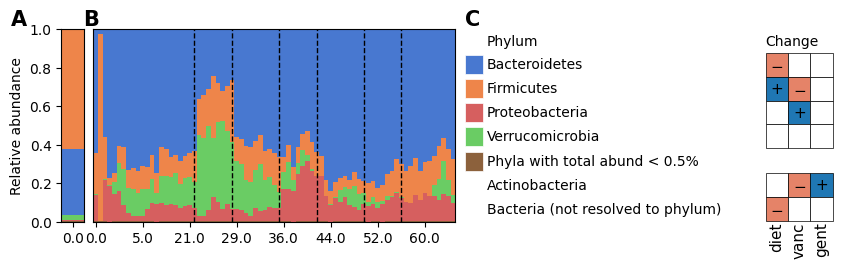

In [32]:
pert_abbreviations = {'High Fat Diet': 'diet', 'Vancomycin': 'vanc', 'Gentamicin': 'gent'}
healthy_abundant_deseq_phylum_df, healthy_sparse_deseq_phylum_df = make_deseq_df_phylum(healthy_deseq_dir, set(phylum_palette.keys()), 'healthy')
fig, ax = render_fig_phylum_level(
    subjset_healthy, '2', 
    healthy_phylum_relabund_df, inoc_healthy_phylum_relabund_df, 
    healthy_phylum_to_keep, healthy_phylum_to_remove, 
    healthy_abundant_deseq_phylum_df, healthy_sparse_deseq_phylum_df, 
    figsize=(10, 2.5),
    pert_abbreviations=pert_abbreviations,
)

plt.savefig("plots/supp_fig_phylum_healthy.pdf", bbox_inches='tight')
healthy_abundant_deseq_phylum_df.to_csv(table_dir / "healthy_abundant_deseq_phylum.tsv", sep='\t', index=True)
healthy_sparse_deseq_phylum_df.to_csv(table_dir / "healthy_sparse_deseq_phylum.tsv", sep='\t', index=True)

Plotting differential abundance heatmap for: ['High Fat Diet', 'Vancomycin', 'Gentamicin']
rendering heatmap row for phylum Bacteroidetes
rendering heatmap row for phylum Firmicutes
rendering heatmap row for phylum Proteobacteria
rendering heatmap row for phylum Verrucomicrobia
Plotting differential abundance heatmap for: ['High Fat Diet', 'Vancomycin', 'Gentamicin']
rendering heatmap row for phylum Actinobacteria


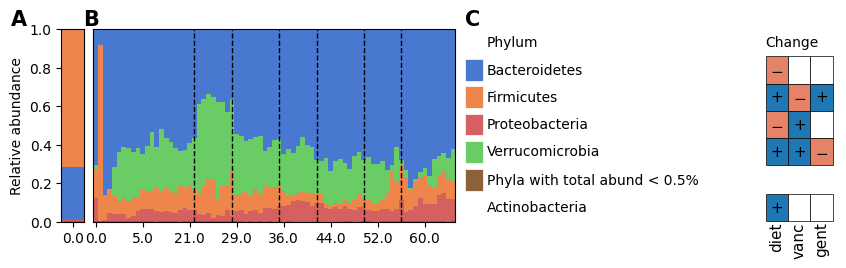

In [34]:
pert_abbreviations = {'High Fat Diet': 'diet', 'Vancomycin': 'vanc', 'Gentamicin': 'gent'}
uc_abundant_deseq_phylum_df, uc_sparse_deseq_phylum_df = make_deseq_df_phylum(uc_deseq_dir, set(phylum_palette.keys()), 'uc')
fig, ax = render_fig_phylum_level(
    subjset_uc, '6', 
    uc_phylum_relabund_df, inoc_uc_phylum_relabund_df, 
    uc_phylum_to_keep, uc_phylum_to_remove, 
    uc_abundant_deseq_phylum_df, uc_sparse_deseq_phylum_df, 
    figsize=(10, 2.5),
    pert_abbreviations=pert_abbreviations,
)
plt.savefig("plots/supp_fig_phylum_uc.pdf", bbox_inches='tight')
uc_abundant_deseq_phylum_df.to_csv(table_dir / "uc_abundant_deseq_phylum.tsv", sep='\t', index=True)
uc_sparse_deseq_phylum_df.to_csv(table_dir / "uc_sparse_deseq_phylum.tsv", sep='\t', index=True)